In [3]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [4]:
cancer_rays_dir = os.listdir("./input/IDC_regular_ps50_idx5") 
all_rays_dir = "all_rays_dir"
cancer_rays_dir_str = "./input/IDC_regular_ps50_idx5/"

In [4]:
if not os.path.exists(all_rays_dir):
    os.makedirs(all_rays_dir)
for patient in cancer_rays_dir:   
    path_0 = os.path.join(cancer_rays_dir_str, patient, '0')
    path_1 = os.path.join(cancer_rays_dir_str, patient, '1')
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [5]:
all_rays_dir_lst = os.listdir(all_rays_dir) 
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])


In [7]:
# Extract target label from the filename
def extract_target(x):
    return int(x.split('_')[4][5])

In [8]:
data['target'] = data['image_id'].apply(extract_target)

In [7]:
# Feature extraction function using HOG with resizing
def extract_features(image_path):
    image = mpimg.imread(image_path)
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)
    # Resize image to 16x16 for HOG compatibility
    image_resized = resize(image, (16, 16), anti_aliasing=True)
    features, _ = hog(image_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [8]:
features = []
targets = []
for idx, row in data.iterrows():
    path = os.path.join(all_rays_dir, row['image_id'])
    features.append(extract_features(path))
    targets.append(row['target'])

X = np.array(features)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [10]:
y_pred = knn.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76     39622
           1       0.40      0.38      0.39     15883

    accuracy                           0.66     55505
   macro avg       0.58      0.58      0.58     55505
weighted avg       0.65      0.66      0.66     55505

Accuracy: 0.657400234213134


In [11]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [12]:
y_pred = rfc.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83     39622
           1       0.00      0.00      0.00     15883

    accuracy                           0.71     55505
   macro avg       0.36      0.50      0.42     55505
weighted avg       0.51      0.71      0.59     55505

Accuracy: 0.7138455994955409


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
dt = DecisionTreeClassifier(
    max_depth=8,              
    min_samples_split=10,     
    min_samples_leaf=5,       
    criterion='entropy',      
    random_state=42
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [20]:
y_pred = dt.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83     39622
           1       0.00      0.00      0.00     15883

    accuracy                           0.71     55505
   macro avg       0.36      0.50      0.42     55505
weighted avg       0.51      0.71      0.59     55505

Accuracy: 0.713701468336186


In [13]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [14]:
y_pred = logistic_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83     39622
           1       0.67      0.01      0.01     15883

    accuracy                           0.71     55505
   macro avg       0.69      0.50      0.42     55505
weighted avg       0.70      0.71      0.60     55505

Accuracy: 0.7147824520313485


In [18]:
base_estimators = [
    ('dtc', DecisionTreeClassifier(
    max_depth=8,              
    min_samples_split=10,     
    min_samples_leaf=5,       
    criterion='entropy',      
    random_state=42
)),
    ('rfc', RandomForestClassifier(max_depth=2, random_state=0)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
]

meta_classifier = SVC(kernel='linear', probability=True, random_state=42)
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_classifier)

stacking_model.fit(X_train, y_train)

y_pred_meta = stacking_model.predict(X_test)
print("Meta-Model Classification Report:\n", classification_report(y_test, y_pred_meta))
print("Meta-Model Accuracy:", accuracy_score(y_test, y_pred_meta))

Meta-Model Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83     39622
           1       0.00      0.00      0.00     15883

    accuracy                           0.71     55505
   macro avg       0.36      0.50      0.42     55505
weighted avg       0.51      0.71      0.59     55505

Meta-Model Accuracy: 0.7138455994955409


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Healthy patches

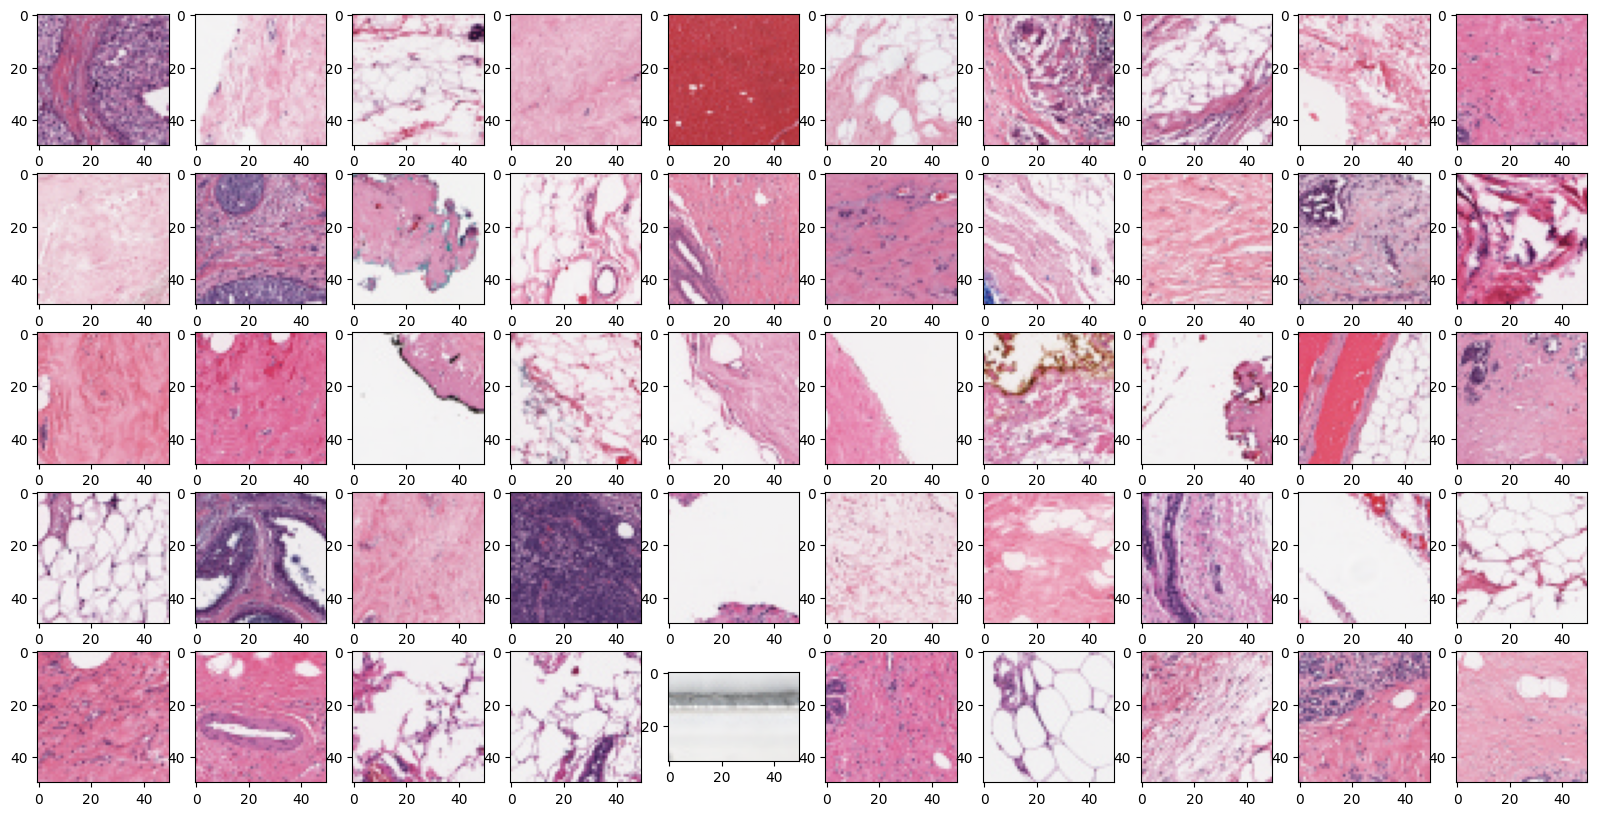

In [10]:
data.target = data.target.astype(int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

## Cancer patches

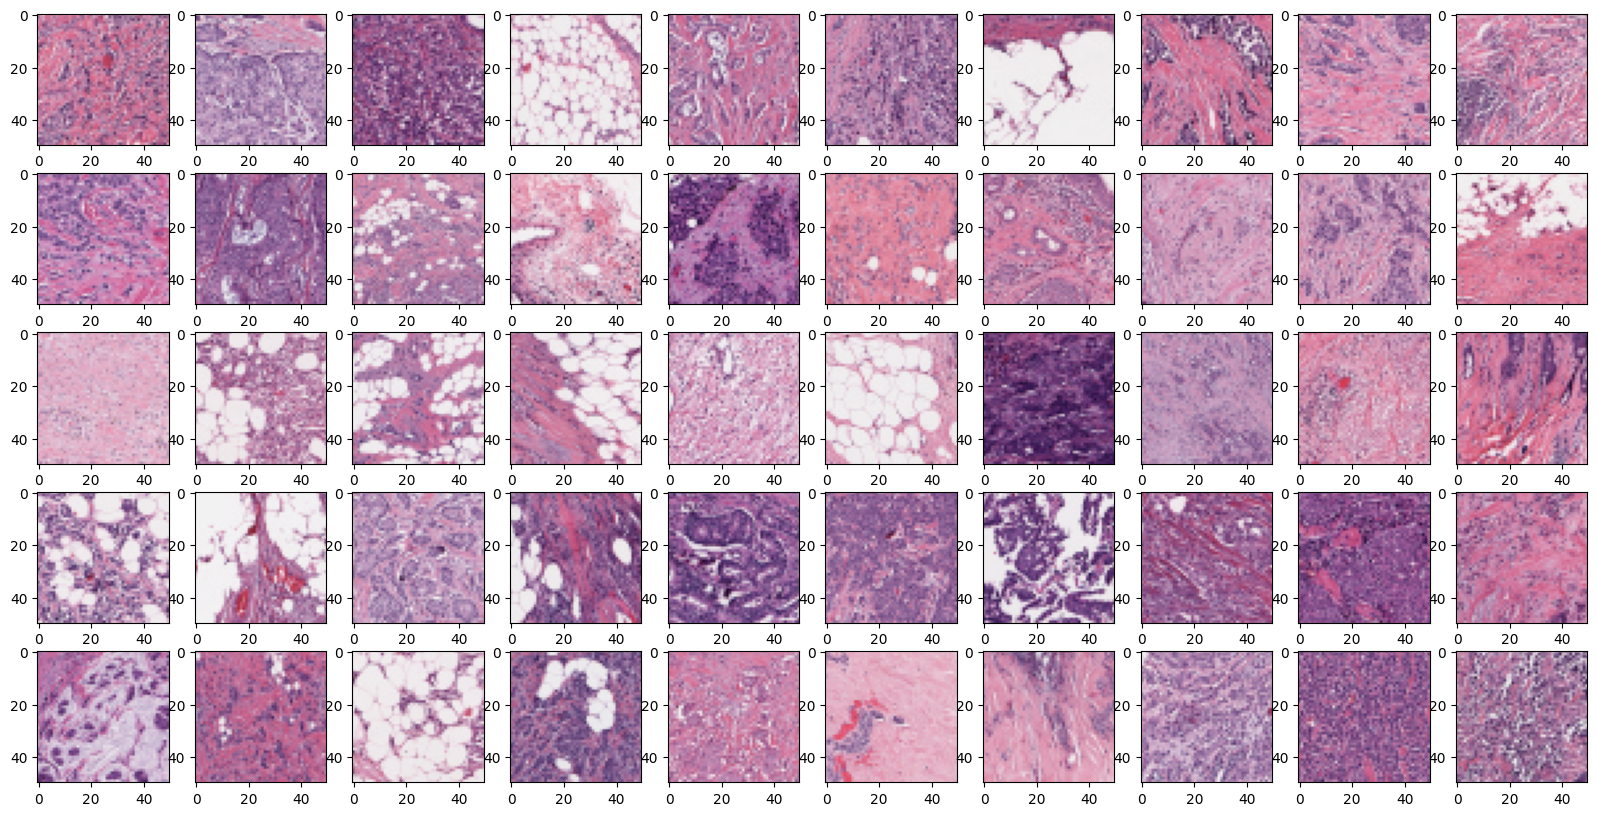

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [12]:
import numpy as np

# Індекси кожного класу
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

# Розмір меншого класу
n_samples = len(class_1_indices)

# Випадковий вибір із класу 0
np.random.seed(42)  # Для відтворюваності
undersampled_class_0_indices = np.random.choice(class_0_indices, n_samples, replace=False)

# Об'єднання undersampled класу 0 з класом 1
balanced_indices = np.concatenate([undersampled_class_0_indices, class_1_indices])

# Нові збалансовані X і y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

print(Counter(y_balanced))

NameError: name 'y' is not defined